In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
pd.set_option("display.max_columns", 111)
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score

from category_encoders import OneHotEncoder

import tensorflow.keras as tfk

In [85]:
data = pd.read_excel('dataset.xlsx')
data['SARS-Cov-2 exam result'] = data['SARS-Cov-2 exam result'].map(dict(negative=0, positive=1))
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]
data['Urine___pH'] = data['Urine___pH'].map(lambda x: -100 if isinstance(x, str) else x).astype(float)
data['Urine___Leukocytes'] = data['Urine___Leukocytes'].map(lambda x: 500 if x == '<1000' else x).astype(float)
data['Patient_addmited_to_semi_intensive_unit__1_yes__0_no_'] *= 2
data['Patient_addmited_to_intensive_care_unit__1_yes__0_no_'] *= 3
data['severity'] = data[['Patient_addmited_to_regular_ward__1_yes__0_no_', 
                         'Patient_addmited_to_semi_intensive_unit__1_yes__0_no_', 
                         'Patient_addmited_to_intensive_care_unit__1_yes__0_no_']].max(axis=1)





In [86]:
X = data.iloc[:, 6:-1]
X['Patient_age_quantile'] = data['Patient_age_quantile']
X.head()

,Hematocrit,Hemoglobin,Platelets,Mean_platelet_volume_,Red_blood_Cells,Lymphocytes,Mean_corpuscular_hemoglobin_concentration__MCHC_,Leukocytes,Basophils,Mean_corpuscular_hemoglobin__MCH_,Eosinophils,Mean_corpuscular_volume__MCV_,Monocytes,Red_blood_cell_distribution_width__RDW_,Serum_Glucose,Respiratory_Syncytial_Virus,Influenza_A,Influenza_B,Parainfluenza_1,CoronavirusNL63,Rhinovirus_Enterovirus,Mycoplasma_pneumoniae,Coronavirus_HKU1,Parainfluenza_3,Chlamydophila_pneumoniae,Adenovirus,Parainfluenza_4,Coronavirus229E,CoronavirusOC43,Inf_A_H1N1_2009,Bordetella_pertussis,Metapneumovirus,Parainfluenza_2,Neutrophils,Urea,Proteina_C_reativa_mg_dL,Creatinine,Potassium,Sodium,Influenza_B__rapid_test,Influenza_A__rapid_test,Alanine_transaminase,Aspartate_transaminase,Gamma_glutamyltransferase_,Total_Bilirubin,Direct_Bilirubin,Indirect_Bilirubin,Alkaline_phosphatase,Ionized_calcium_,Strepto_A,Magnesium,pCO2__venous_blood_gas_analysis_,Hb_saturation__venous_blood_gas_analysis_,Base_excess__venous_blood_gas_analysis_,pO2__venous_blood_gas_analysis_,Fio2__venous_blood_gas_analysis_,Total_CO2__venous_blood_gas_analysis_,pH__venous_blood_gas_analysis_,HCO3__venous_blood_gas_analysis_,Rods__,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine___Esterase,Urine___Aspect,Urine___pH,Urine___Hemoglobin,Urine___Bile_pigments,Urine___Ketone_Bodies,Urine___Nitrite,Urine___Density,Urine___Urobilinogen,Urine___Protein,Urine___Sugar,Urine___Leukocytes,Urine___Crystals,Urine___Red_blood_cells,Urine___Hyaline_cylinders,Urine___Granular_cylinders,Urine___Yeasts,Urine___Color,Partial_thromboplastin_time__PTT__,Relationship__Patient_Normal_,International_normalized_ratio__INR_,Lactic_Dehydrogenase,Prothrombin_time__PT___Activity,Vitamin_B12,Creatine_phosphokinase__CPK__,Ferritin,Arterial_Lactic_Acid,Lipase_dosage,D_Dimer,Albumin,Hb_saturation__arterial_blood_gases_,pCO2__arterial_blood_gas_analysis_,Base_excess__arterial_blood_gas_analysis_,pH__arterial_blood_gas_analysis_,Total_CO2__arterial_blood_gas_analysis_,HCO3__arterial_blood_gas_analysis_,pO2__arterial_blood_gas_analysis_,Arteiral_Fio2,Phosphor,ctO2__arterial_blood_gas_analysis_,Patient_age_quantile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

- simples fato de ser não-nulo possui informação, não é nulo at random
- em que momento deve ser feita a previsão? após exames? após detecção? na admissão?
- sintomas relatados como features

In [87]:
kf = KFold(2, shuffle=True, random_state=0)

In [88]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_squared_error, cohen_kappa_score, classification_report

In [89]:
from category_encoders import OrdinalEncoder

In [90]:
cats = X.select_dtypes(include=object).columns.tolist()

In [91]:
full_nan = X.isnull().mean(axis=1) == 1
X = X[~full_nan]
data = data[~full_nan]

In [100]:
for tr, ts in kf.split(X):
    Xtr = X.iloc[tr]
    Xts = X.iloc[ts]
    ytr = data.iloc[tr]['severity']
    yts = data.iloc[ts]['severity']
    
    
    #Xtr.loc[:, cats] = Xtr.loc[:, cats].fillna("missing")
    
    enc = OrdinalEncoder(cols=cats)
    Xtr = enc.fit_transform(Xtr)#.fillna(-10)
    Xts = enc.transform(Xts)#.fillna(-10)
    

    
    #mdl = LGBMRegressor(random_state=200, class_weight='balanced', n_estimators=100, 
    #                     learning_rate=0.01, num_leaves=2**5)
    mdl = LGBMClassifier(random_state=200, class_weight='balanced', n_estimators=200, 
                         learning_rate=0.01, num_leaves=2**4)
    mdl.fit(Xtr, ytr)
    
    p = mdl.predict(Xts)
    
    print("Kappa = ", cohen_kappa_score(yts,p))
    
    
    #plot_tree(mdl)
    #break

Kappa =  0.27746010070837235
Kappa =  0.18061535976292464


In [101]:
print(classification_report(yts, p))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2722
           1       0.09      0.49      0.16        47
           2       0.08      0.23      0.12        26
           3       0.10      0.37      0.15        27

    accuracy                           0.85      2822
   macro avg       0.31      0.49      0.34      2822
weighted avg       0.96      0.85      0.90      2822



In [114]:
X['Influenza_B'].value_counts()

not_detected    1277
detected          77
Name: Influenza_B, dtype: int64

In [102]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [103]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtr)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


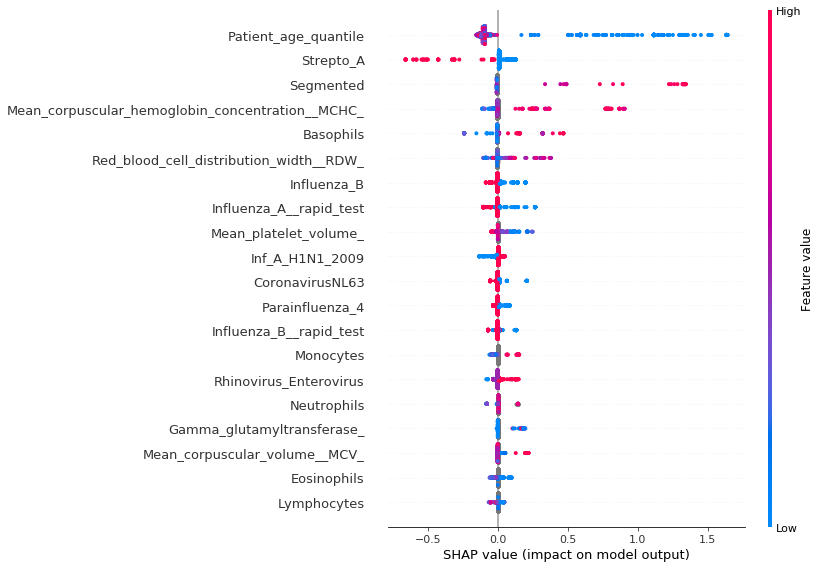

In [104]:
shap.summary_plot(shap_values[-1], Xtr)

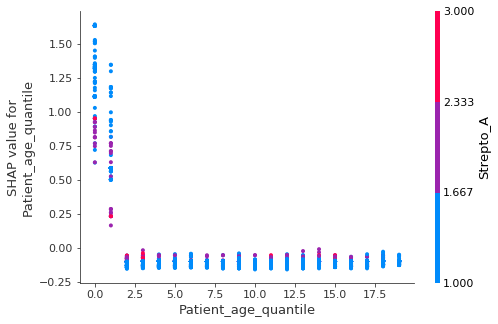

In [106]:
shap.dependence_plot('Patient_age_quantile',shap_values[-1], Xtr, interaction_index='Strepto_A')
## https://www.healthline.com/health/leukopenia#causes

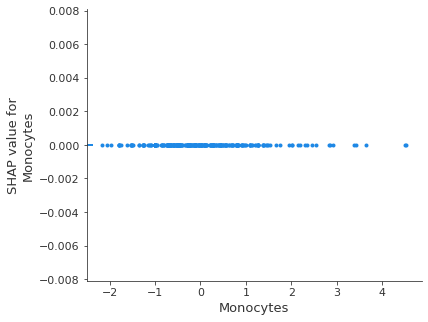

In [33]:
shap.dependence_plot('Monocytes',shap_values, Xtr, interaction_index=None)
# https://en.wikipedia.org/wiki/Monocyte#Monocytosis

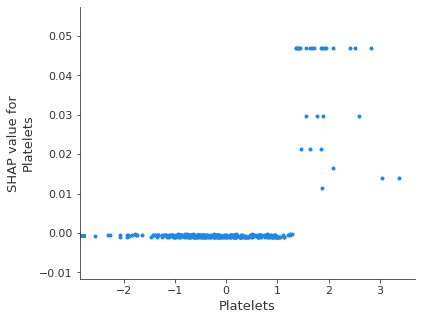

In [35]:
shap.dependence_plot('Platelets',shap_values, Xtr, interaction_index=None)

In [57]:
#https://www.researchgate.net/figure/Means-standard-deviations-of-total-leukocyte-count-and-differential-percentages-in_tbl2_6127755